<a href="https://colab.research.google.com/github/parshwa1999/Map-Segmentation/blob/master/ResNet101_RoadMapSeg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Semantic Segmentation of Aerial Images
###Road Training

####Mounting Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')
base_path = "gdrive/My\ Drive/MapSegClean/"
%cd gdrive/My\ Drive/MapSegClean/

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).
/content/gdrive/My Drive/MapSegClean


####Importing Libraries

In [0]:
import cv2
import numpy as np
import h5py

In [3]:
import tensorflow as tf
from keras import backend as K

Using TensorFlow backend.


In [0]:
from keras.models import Model, load_model
import tensorflow as tf
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import optimizers
from keras.layers import BatchNormalization
from tensorflow.keras.metrics import MeanIoU
import keras
from keras.applications.resnet50 import ResNet50

from skimage import color
import pickle

####Read Data From h5 files

In [0]:
h5f = h5py.File('clean_roadlabel.h5','r')
roadlabel = h5f['clean_roadlabel'][:]
h5f.close()

h5f = h5py.File('clean_road.h5','r')
road = h5f['clean_road'][:]
h5f.close()

In [6]:
#for i in range(road.shape[0]):
#  cv2.imwrite("Road/" + str(i) + ".png", road[i])

#for i in range(roadlabel.shape[0]):
#  cv2.imwrite("RoadLabel/" + str(i) + ".png", roadlabel[i])
pip install -U segmentation-models

Requirement already up-to-date: segmentation-models in /usr/local/lib/python3.6/dist-packages (1.0.1)


####Loss Function

In [0]:
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  return iou

def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


####Preprocecssing Data

In [8]:
print(roadlabel.shape)

roadlabelgray = []

for i in range(roadlabel.shape[0]):
  roadlabelgray.append(cv2.cvtColor(roadlabel[i], cv2.COLOR_BGR2GRAY))

roadlabelgray = np.asarray(roadlabelgray)

roadlabel = np.expand_dims(roadlabelgray, -1)

del roadlabelgray

print(roadlabel.shape)

(22911, 256, 256, 3)
(22911, 256, 256, 1)


In [0]:
seed = 56
IMAGE_HEIGHT = IMAGE_WIDTH = 256
NUM_CHANNELS = 3

In [21]:
roadlabel_0 = roadlabel[0:10000]/255
print(roadlabel_0.shape)
roadlabel_0 = roadlabel_0.astype(np.float16)



(10000, 256, 256, 1)


In [29]:
road_0 = road[0:10000].astype(np.float16)/255
print(road_0.shape)



(10000, 256, 256, 3)


In [30]:
np.dtype(road_0[0,0,0,0])
#roadlabel_0 = roadlabel_0.astype(np.float16)
#del roadlabel_0

dtype('float16')

In [0]:
#roadlabel = roadlabel[:,0:224,0:224]
#print(roadlabel.shape)
#road = road[:,0:224,0:224]
#print(road.shape)

roadlabel_t = roadlabel[0:10000]/255
print(roadlabel_t.shape)
road_t = road[0:10000]/255
print(road_t.shape)

roadlabel_v = roadlabel[10000:11000]/255
print(roadlabel_v.shape)
road_v = road[10000:11000]/255
print(road_v.shape)


####Model

In [31]:
from segmentation_models import Unet
from segmentation_models import get_preprocessing
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score

Segmentation Models: using `keras` framework.


In [32]:
model = Unet('resnet101', input_shape=(256, 256, 3), encoder_weights=None)
#model = Unet(input_shape=(256, 256, 3), weights=None, activation='elu')
model.summary()














Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
data (InputLayer)               (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
bn_data (BatchNormalization)    (None, 256, 256, 3)  9           data[0][0]                       
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 262, 262, 3)  0           bn_data[0][0]                    
__________________________________________________________________________________________________
conv0 (Conv2D)                  (None, 128, 128, 64) 9408        zero_padding2d_1[0][0]           
_______________________________________________________________________________

####Hyperparameters


In [0]:
LEARNING_RATE = 0.0001
BATCH_SIZE = 32

####Path to save Model

In [0]:
model_path = "Models/Resnet_road_weights.h5"

In [35]:
import sys
def sizeof_fmt(num, suffix='B'):
    ''' by Fred Cirera,  https://stackoverflow.com/a/1094933/1870254, modified'''
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f %s%s" % (num, 'Yi', suffix)

for name, size in sorted(((name, sys.getsizeof(value)) for name, value in locals().items()),
                         key= lambda x: -x[1])[:10]:
    print("{:>30}: {:>8}".format(name, sizeof_fmt(size)))

                          road:  4.2 GiB
                        road_0:  3.7 GiB
                   roadlabel_0:  1.2 GiB
                           _24:  1.2 GiB
                         Model:  2.0 KiB
                        Conv2D:  2.0 KiB
            BatchNormalization:  2.0 KiB
                  MaxPooling2D:  1.4 KiB
                       Dropout:  1.0 KiB
                        Lambda:  1.0 KiB


####Callbacks

In [36]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc=TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://668c0029.ngrok.io


In [0]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from datetime import datetime

checkpointer = ModelCheckpoint(model_path,
                             monitor="val_loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

In [0]:
earlystopper = EarlyStopping(monitor = 'val_loss', 
                             min_delta = 0, 
                             patience = 5,
                             mode='auto',
                            restore_best_weights = True)

In [39]:
lr_reducer = ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1,
                               epsilon=1e-4)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:1335: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


####Compile Model

In [42]:
opt = keras.optimizers.adam(LEARNING_RATE)
model.compile(
      optimizer=opt,
      loss=soft_dice_loss,
      metrics=[iou_coef])   

In [43]:
history = model.fit(road_0,
                    roadlabel_0,
                    validation_split = 0.1,
                    epochs=35,
                    batch_size = BATCH_SIZE,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )

with open("History/Resnet_Road_History.pickle", 'wb') as f:
    pickle.dump(history, f)



Train on 9000 samples, validate on 1000 samples


Epoch 1/35
9000/9000 [==============================] - 220s 24ms/step - loss: 0.7786 - iou_coef: 0.1048 - val_loss: 0.7228 - val_iou_coef: 0.1297

Epoch 00001: val_loss improved from inf to 0.72277, saving model to Models/Resnet_road_weights.h5

Epoch 2/35
9000/9000 [==============================] - 184s 20ms/step - loss: 0.5725 - iou_coef: 0.2092 - val_loss: 0.5219 - val_iou_coef: 0.2372

Epoch 00002: val_loss improved from 0.72277 to 0.52194, saving model to Models/Resnet_road_weights.h5
Epoch 3/35
9000/9000 [==============================] - 184s 20ms/step - loss: 0.4360 - iou_coef: 0.2949 - val_loss: 0.4159 - val_iou_coef: 0.3112

Epoch 00003: val_loss improved from 0.52194 to 0.41591, saving model to Models/Resnet_road_weights.h5
Epoch 4/35
9000/9000 [==============================] - 184s 20ms/step - loss: 0.3753 - iou_coef: 0.3425 - val_loss: 0.3734 - val_iou_coef: 0.3419

Epoch 00004: val_loss improved from 0.41591 to 0.3734

In [0]:
#import pickle
#with open("History/Road_History.pickle", 'rb') as f:
#    history = pickle.load(f)

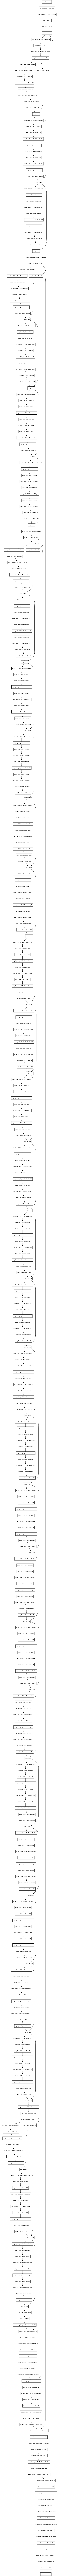

In [44]:
from keras.utils import plot_model
plot_model(model, to_file='History/Resnet_road_model.png')

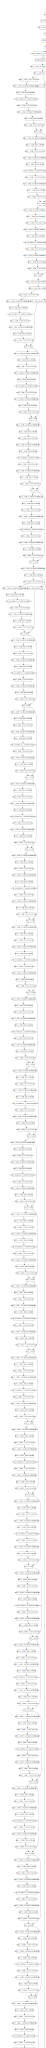

In [45]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

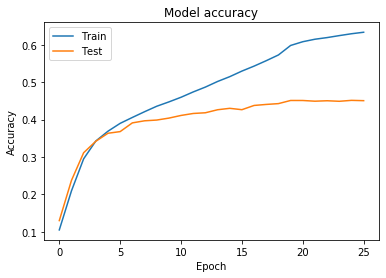

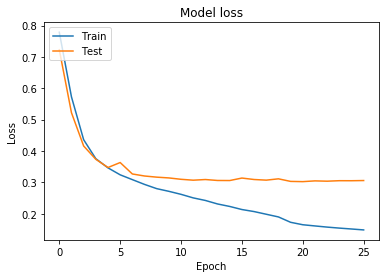

In [46]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(history.history['iou_coef'])
plt.plot(history.history['val_iou_coef'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
print(history.history.keys())

dict_keys(['val_loss', 'val_iou_coef', 'loss', 'iou_coef', 'lr'])


In [0]:
road_1 = road[10000 : len(road)]
roadlabel_1 = roadlabel[10000 : len[roadlabel]]

model.load_weights("Models/road_weights.h5")

history_1 = model.fit(road_1,
                    roadlabel_1/255,
                    validation_split = 0.1,
                    epochs=20,
                    batch_size = 32,
                    callbacks = [checkpointer, earlystopper, lr_reducer, TensorBoardColabCallback(tbc)]
                       )
#del road, roadlabel

Train on 4500 samples, validate on 500 samples
Epoch 1/100
4500/4500 [==============================] - 624s 139ms/step - loss: 0.2877 - iou_coef: 0.4938 - val_loss: 0.2783 - val_iou_coef: 0.5007

Epoch 00001: val_loss improved from 0.28103 to 0.27831, saving model to Models/colab_weights.h5
Epoch 2/100
4500/4500 [==============================] - 626s 139ms/step - loss: 0.2855 - iou_coef: 0.5002 - val_loss: 0.2729 - val_iou_coef: 0.5108

Epoch 00002: val_loss improved from 0.27831 to 0.27294, saving model to Models/colab_weights.h5
Epoch 3/100
4500/4500 [==============================] - 619s 138ms/step - loss: 0.2829 - iou_coef: 0.5073 - val_loss: 0.2711 - val_iou_coef: 0.5164

Epoch 00003: val_loss improved from 0.27294 to 0.27112, saving model to Models/colab_weights.h5
Epoch 4/100
4500/4500 [==============================] - 617s 137ms/step - loss: 0.2809 - iou_coef: 0.5152 - val_loss: 0.2736 - val_iou_coef: 0.5180

Epoch 00004: val_loss did not improve from 0.27112
Epoch 5/100
45

####Train Further